사랑의 열매

김성중 201904129
우사랑 201904217

# 어텐션의 구조
- s2s의 문제점 : encoder의 출력이 고정 길이 벡터
-> 긴 문장이 입력되어도 같은 길이의 벡터로 출력
-> 정보손실 발생
- Encoder 개선
- 출력 길이 입력 문장의 길이에 따라 바꿈
- 시각별 LSTM계층의 은닉 상태 벡터를 모두 사용

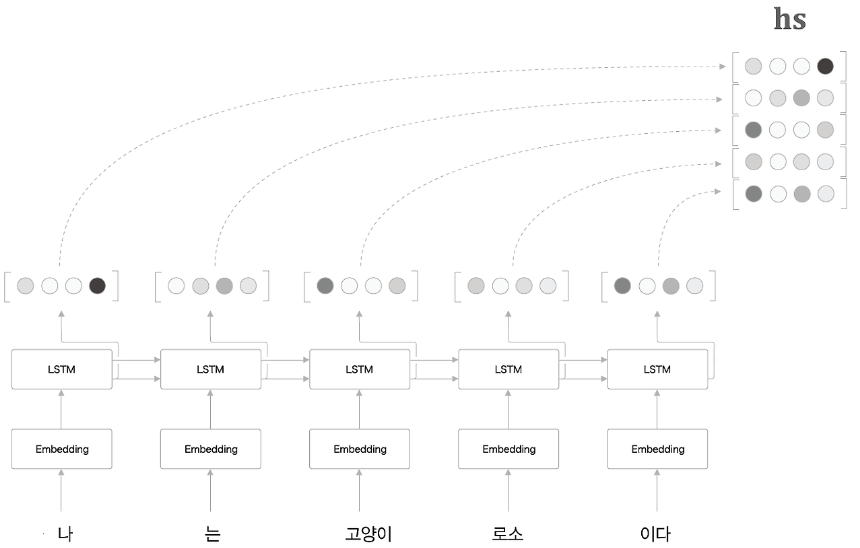

## decoder의 개선
- s2s는 마지막 백터만 가져감
- hs 전부를 활용할 수 있도록 만듬

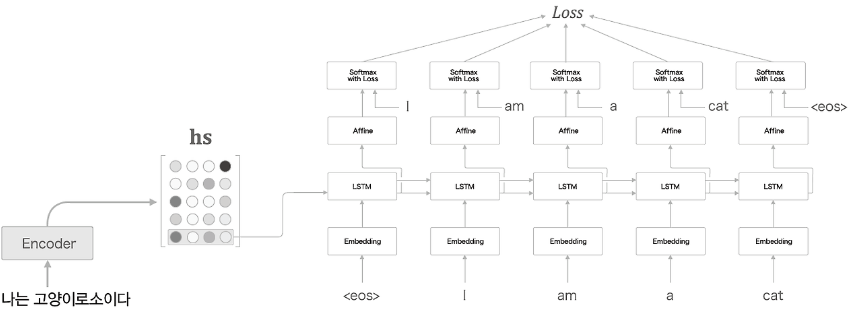

# 가중치 합 구하기 Weight sum
hs와 a(단어의 중요도를 나타내는 가중치)를 곱하여 맥락 벡터를 만듬


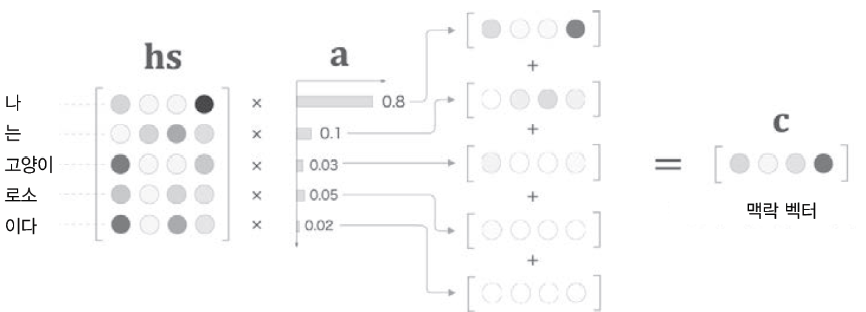

In [ ]:
import numpy as np

In [ ]:
# hs ; 각 단어의 벡터
# a : 각 단어의 중요도를 나타내는 가중
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1).repeat(H, axis = 2)
        t = hs * ar
        c = np.sum(t, axis = 1)
        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape

        dt = dc.reshape(N, 1, H).repeat(T, axis = 1) # sum의 역전파
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis = 2) # repeat의 역전파

        return dhs, da


In [ ]:
# T : 시계열 길이 , H : 은닉 상태 벡터의 원소 수
T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])
print(a.shape)

ar = a.reshape(5, 1)
print(ar.shape)

ar = a.reshape(5, 1).repeat(H, axis=1)
print(ar.shape)


t = hs * ar
print(t.shape)

c = np.sum(t, axis = 0)
print(c.shape)

(5,)
(5, 1)
(5, 4)
(5, 4)
(4,)


## Decoder의 개선 2
- 가중치 a를 구하는 방법
- attentionweight

- h = LSTM 계층의 은닉 상태 벡터

- 목표는 h가 hs의 각 단어 벡터와 얼마나 "비슷한가"를 수치로 나타내는 것이다.

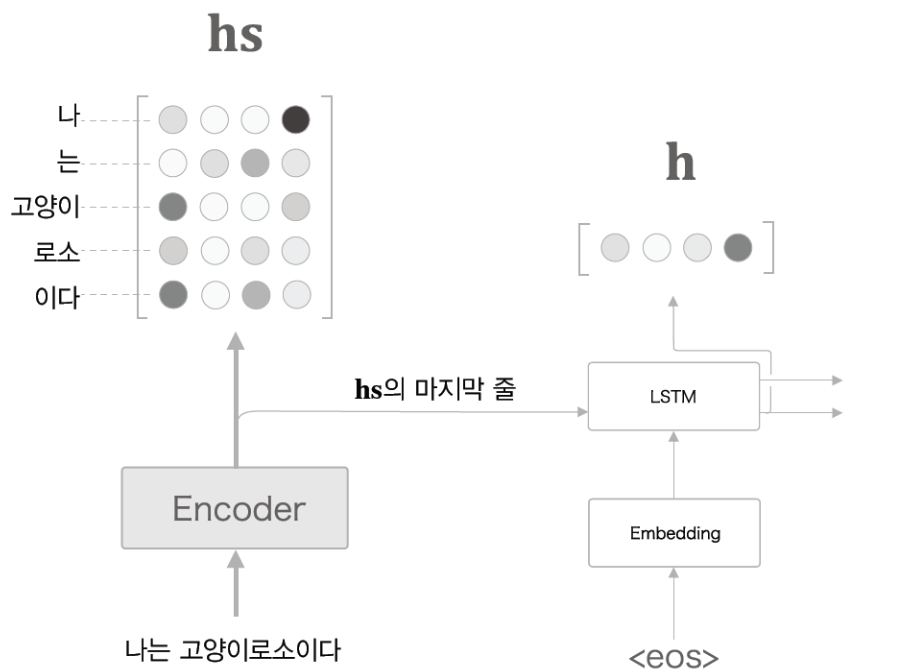

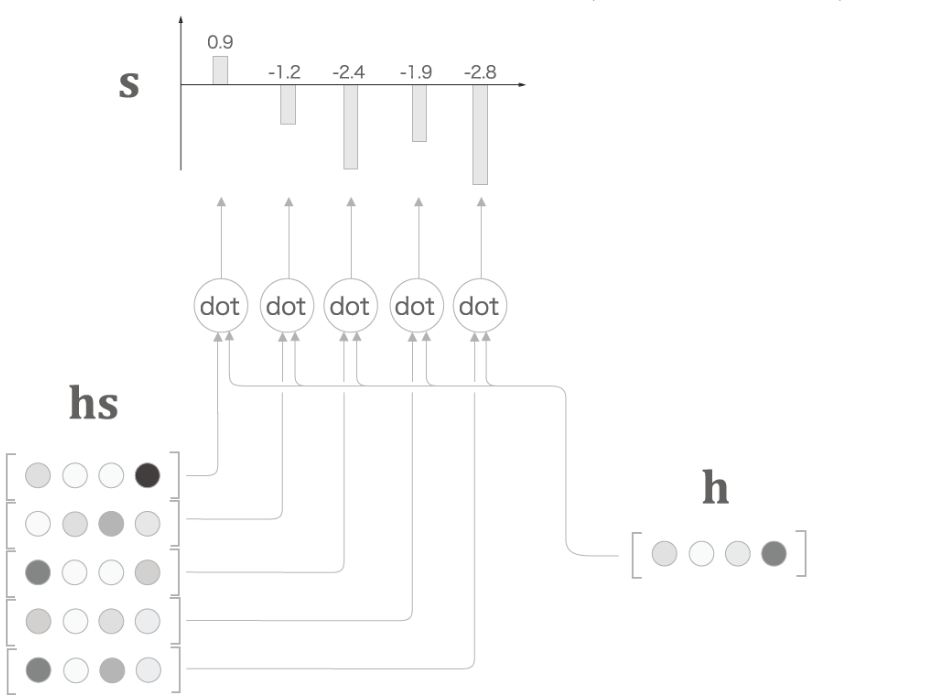

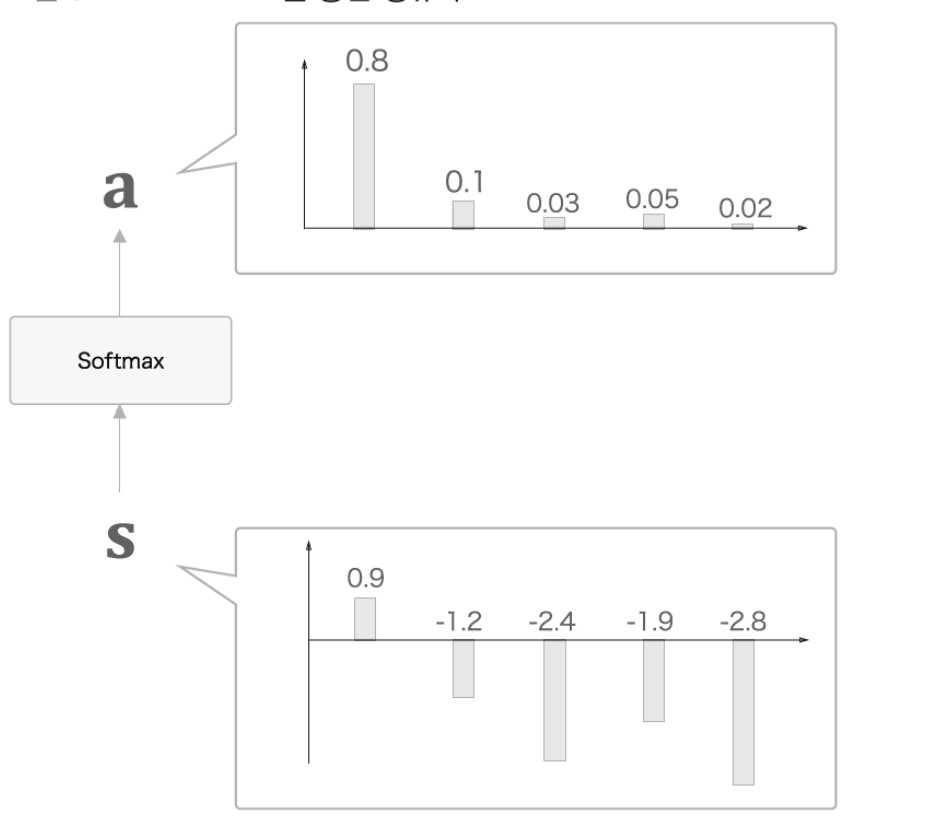

In [ ]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

## Attention

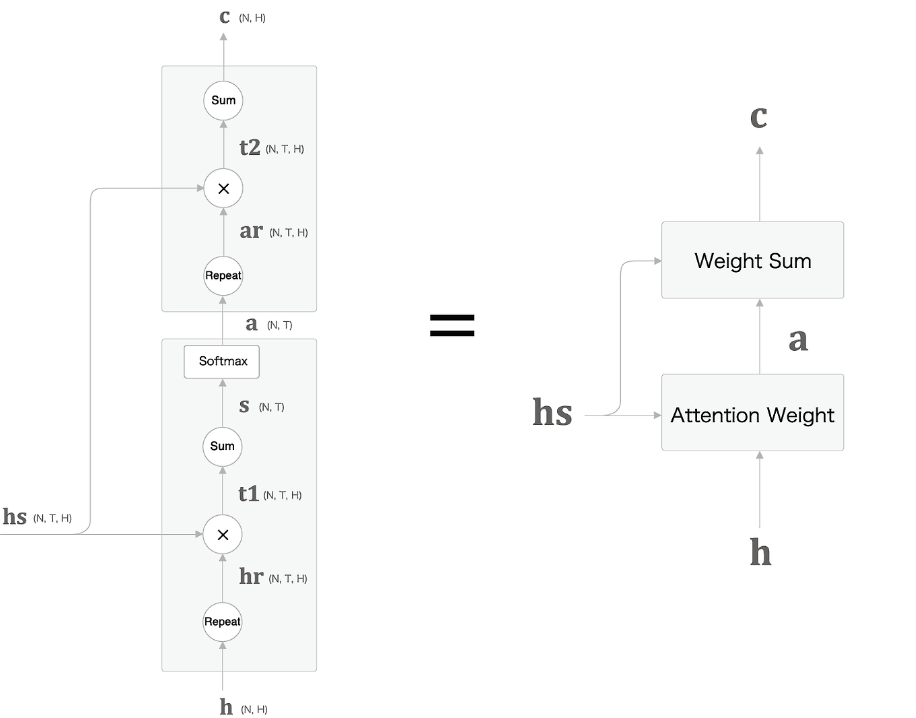

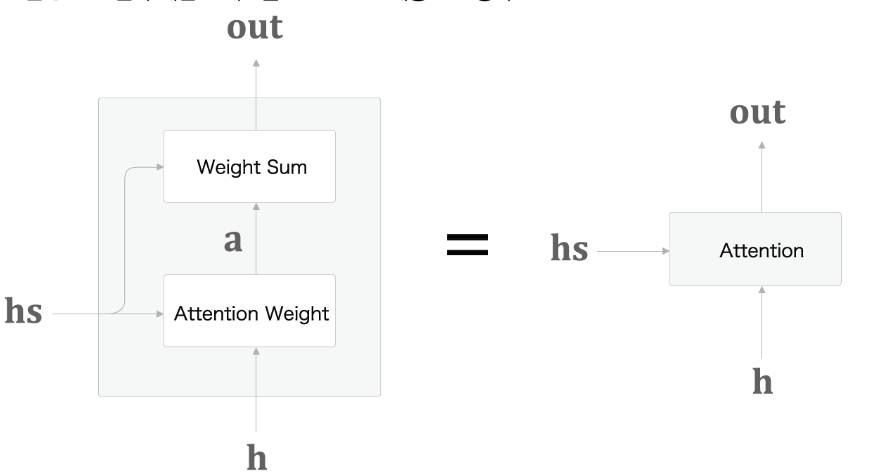

In [ ]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh